In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cufflinks as cf
import chart_studio.plotly as py
import seaborn as sns
import plotly.express as px
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
init_notebook_mode(connected=True)
cf.go_offline()

In [10]:
co2 = pd.read_csv('./dataset/co2_data.csv', index_col='date', parse_dates=True)
co2 = co2.asfreq('MS') # Change frequency to month
co2 = co2.fillna(method='ffill')


,co2
date,
1958-03-01,315.70
1958-04-01,317.45
1958-05-01,317.51
1958-06-01,317.24
1958-07-01,315.86
...,...
2020-06-01,416.38
2020-07-01,414.38
2020-08-01,412.55


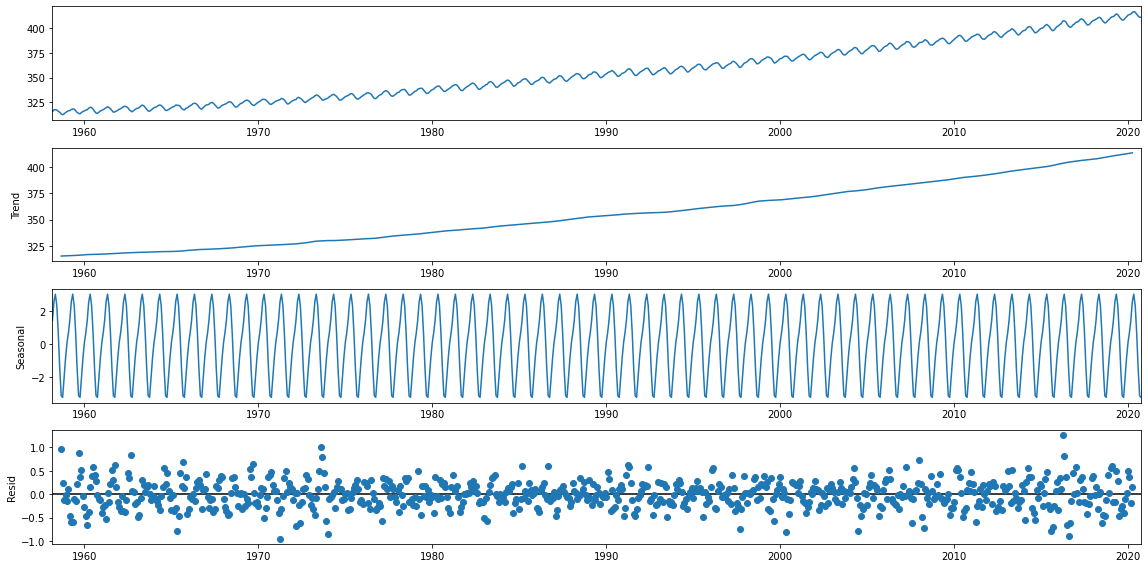

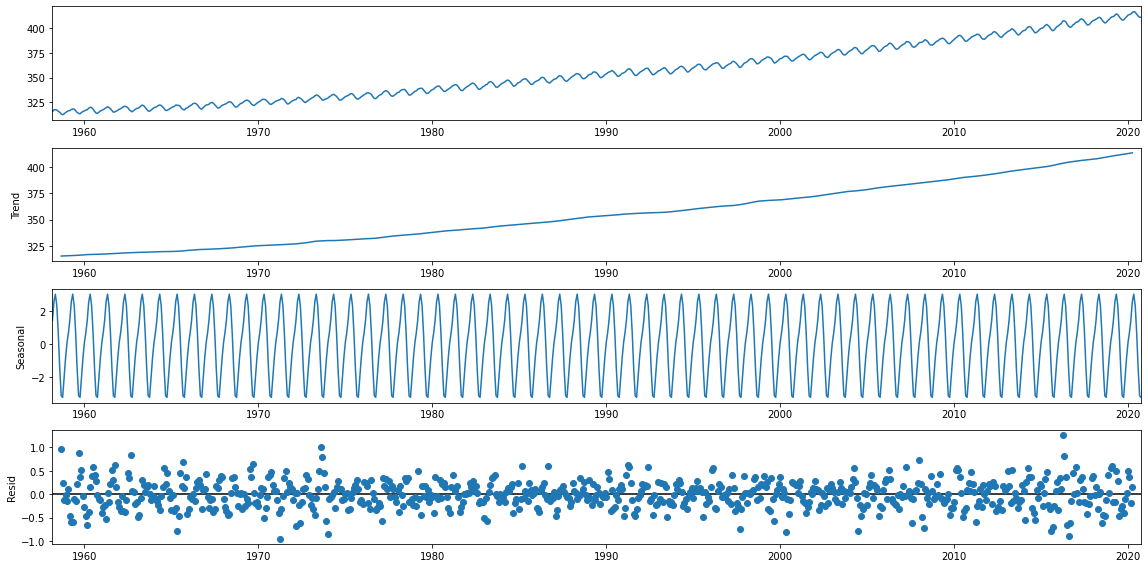

In [34]:
# We verify that there is a seasonal component
# 看趨勢、殘差、季節影響
sns.mpl.rc('figure',figsize=(16, 8))
pic = seasonal_decompose(co2, model='add')
pic.plot()

# Seasonal Autoregressive Integrated Moving Average
We were trying to force seasonal data which is why we were getting imperfect results. With SARIMA we use an additional set of parameters that describe seasonal components of our model (P,D,Q)m.

P : Seasonal Regression
D : Differencing
Q : Moving Average
m : Rows in Each Season Cycle
With monthly data with a yearly seasonal cycle m would equal 12.

In [22]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose

# Run auto_arima as seasonal with m since the season occurs over 12 months
auto_arima(co2, seasonal=True, m=12, trace=True).summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=458.902, Time=2.21 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2447.540, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.64 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1659.710, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2453.523, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=1132.729, Time=1.94 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=776.993, Time=2.35 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=462.685, Time=6.07 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=533.472, Time=5.22 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=1490.235, Time=0.40 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=inf, Time=5.26 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=612.092, Time=5.63 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=472.947, Time=6.42 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=462.299, Time=1.90 sec
 ARIMA(2,1,1)(1,0,1)[12] intercept  

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  752
Model:             SARIMAX(2, 1, 2)x(1, 0, [1], 12)   Log Likelihood                -221.451
Date:                              Wed, 01 Sep 2021   AIC                            458.902
Time:                                      18:06:27   BIC                            495.873
Sample:                                           0   HQIC                           473.147
                                              - 752                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002      0.000      0.911      0.362      -0.000       0.001
ar.L1          0.5467      0.378      1.446      0.148      -0.194       1.288
ar.L2          0.1085      0.169      0.641      0.521      -0.223       0.440
ma.L1         -0.8822      0.376     -2.344      0.019      -1.620      -0.144
ma.L2          0.0336      0.273      0.123      0.902      -0.501       0.568
ar.S.L12       0.9962      0.002    624.113      0.000       0.993       0.999
ma.S.L12      -0.7731      0.030    -25.456      0.000      -0.833      -0.714
sigma2         0.1022      0.005     18.891      0.000       0.092       0.113
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 2.28
Prob(Q):                              0.85   Prob(JB):                         0.32
Heteroskedasticity (H):               1.05   Skew:                            -0.02
Prob(H) (two-sided):                  0.69   Kurtosis:                         3.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

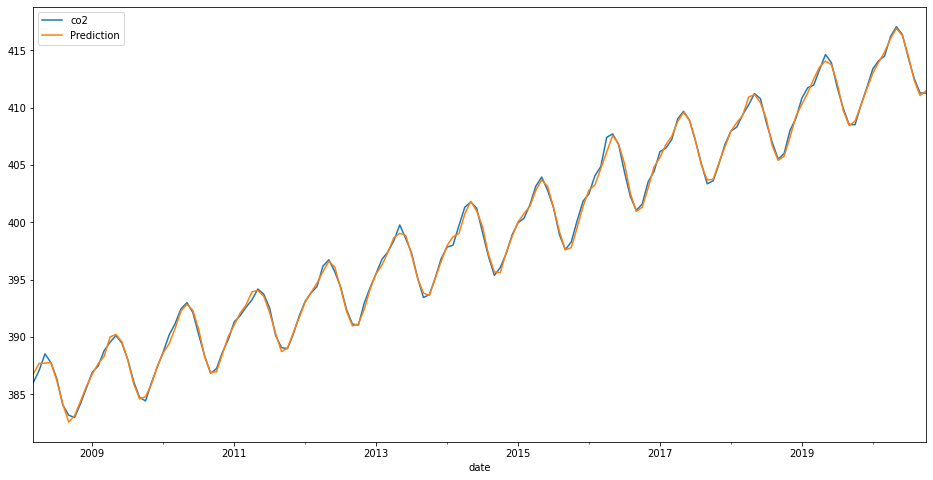

In [26]:
# data:752筆
# train,test
train_co2 = co2[:600]
test_co2 = co2[600:]

# Best model: ARIMA(2,1,2)(1,0,1)[12] intercept
model = SARIMAX(co2, order=(0, 1, 3),seasonal_order=(1, 0, 1, 12))
model_fit = model.fit()

start = len(train_co2)
end = len(train_co2) + len(test_co2) - 1

prediction = model_fit.predict(start, end, typ='linear').rename('Prediction')
test_co2.plot(legend=True, figsize=(16,8))
prediction.plot(legend=True)

# 誤差衡量

In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# The prediction is pretty good being that the mean is 356.8 and the error was 0.346
print(co2.mean()) 
print(np.sqrt(mean_squared_error(test_co2, prediction)))

co2    355.582926
dtype: float64
0.3465189997242091


# 預測未來

<AxesSubplot:xlabel='date'>

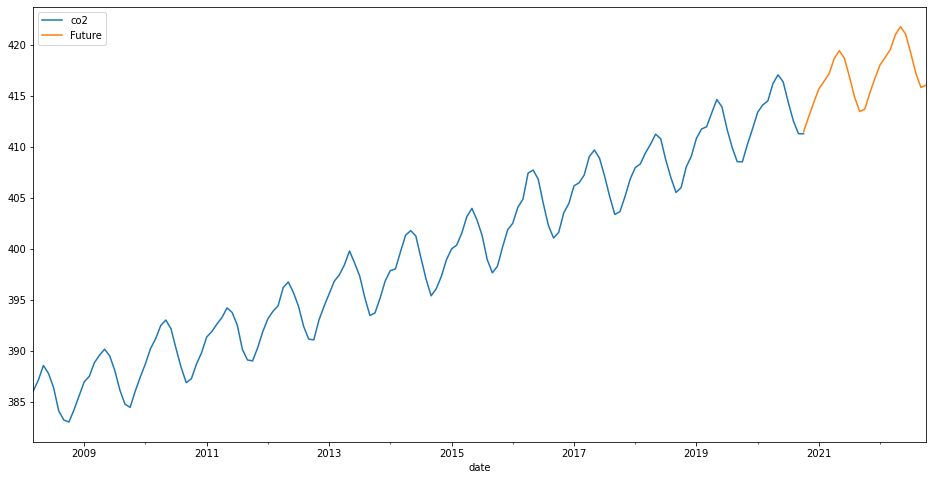

In [30]:
model = SARIMAX(co2, order=(0, 1, 3),seasonal_order=(1, 0, 1, 12))
model_fit = model.fit()

start = len(train_co2)
end = len(train_co2) + len(test_co2) - 1

Future = model_fit.predict(start=end, end=end + 24, typ='linear').rename('Future')
test_co2.plot(legend=True, figsize=(16,8))
Future.plot(legend=True)